# 文本生成--古诗生成器
解决文本生成这个问题的深度学习模型，最常见的是借助于语言模型，或者seq2seq这种encoder-decoder模型。我们这里使用最经典的语言模型，借助LSTM构建一个AI文本生成器。这个demo是使用rnn生成古诗，进行文本创作。
- ## 模型展示<br />
  输入：乱军交白刃，<br />
  输出：一骑出黄尘。汉节同归阙，江帆共逐臣。<br />
- ## 数据展示
<img src="./images/wordcloud_poem.png" width=800px>
- ## 代码结构说明
  - 选取选练数据集
  - 编码数据集
  - 模型训练数据集准备
  - 搭建模型
  - 训练模型
  - 预测

In [1]:
import tensorflow as tf
import math
import re
import numpy as np
from collections import Counter
import random
import time
import os

## 数据集准备
- 选取诗句

In [2]:
data_path = "./data/poetry/poetry.txt"
max_len = 56
disallowed_words = ["（", "）", "(", ")", "__", "《", "》", "【", "】", "[", "]"]
poetry = []
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.readlines()
## 提取诗句数据集
poetry = []
for line in lines:
    context = re.split(r"[：:]", line)
    ## 过滤掉长度不为2的诗句
    if len(context) != 2:
        continue
    ## 取诗句
    poem = context[1]
    if len(poem) > max_len:
        continue
    if any(word in poem for word in disallowed_words):
        continue
    poetry.append(poem.replace("\n", ""))
## 删除空诗句
poetry = [poem for poem in poetry if len(poem) >=6]

In [3]:
print("training data length: ", len(poetry))
for i in range(7):
    print(poetry[i])

training data length:  23880
寒随穷律变，春逐鸟声开。初风飘带柳，晚雪间花梅。碧林青旧竹，绿沼翠新苔。芝田初雁去，绮树巧莺来。
晚霞聊自怡，初晴弥可喜。日晃百花色，风动千林翠。池鱼跃不同，园鸟声还异。寄言博通者，知予物外志。
夏律昨留灰，秋箭今移晷。峨嵋岫初出，洞庭波渐起。桂白发幽岩，菊黄开灞涘。运流方可叹，含毫属微理。
寒惊蓟门叶，秋发小山枝。松阴背日转，竹影避风移。提壶菊花岸，高兴芙蓉池。欲知凉气早，巢空燕不窥。
山亭秋色满，岩牖凉风度。疏兰尚染烟，残菊犹承露。古石衣新苔，新巢封古树。历览情无极，咫尺轮光暮。
翠野驻戎轩，卢龙转征旆。遥山丽如绮，长流萦似带。海气百重楼，岩松千丈盖。兹焉可游赏，何必襄城外。
春蒐驰骏骨，总辔俯长河。霞处流萦锦，风前漾卷罗。水花翻照树，堤兰倒插波。岂必汾阴曲，秋云发棹歌。


In [4]:
## 诗句长度统计
lengths = [len(poem) for poem in poetry]
print(min(lengths), max(lengths))
print(lengths[:10])

6 55
[48, 48, 48, 48, 48, 48, 48, 48, 48, 48]


In [5]:
with open("./data/training_data.txt", "w", encoding="utf-8") as f:
    for iterm in poetry:
        f.write(iterm + "\n")
    f.close()

## 编码数据集

- ### 构建字典

In [6]:
dicts = dict()
for poem in poetry:
    for word in poem:
        if word in dicts:
            dicts[word] += 1
        else:
            dicts[word] = 1
print("create dictionary")
pad = "__PAD__"
unk = "__UNK__"
start = "__START__"
end = "__END__"
start_list = [pad, unk, start, end]
dictionary = start_list + sorted(dicts, key=dicts.get, reverse=True)
print("dictionary word numbers: ", len(dictionary))

create dictionary
dictionary word numbers:  5555


In [7]:
## save dictionary
with open('./data/vocab.txt', 'w', encoding='utf-8') as f:
    for word in dictionary:
        f.write(word + '\n')
    f.close()

- ### 对数据进行编码

In [8]:
word2index = []
word2index = dict((value, key) for key, value in enumerate(dictionary))
index2word = dict((key, value) for key, value in enumerate(dictionary))
data_encoder = []
## 这里每一个诗句加入了开始符号与结束符号
for poem in poetry:
    poem_encoder = [2,]
    for word in poem:
        poem_encoder.append(word2index.get(word, 0))
    poem_encoder.append(3)
    data_encoder.append(poem_encoder)

In [9]:
print("逗号的encoder: ", word2index.get("，", 0))
print("句号的encoder: ", word2index.get("。", 0))
print(data_encoder[:3])

逗号的encoder:  4
句号的encoder:  5
[[2, 48, 185, 404, 1144, 677, 4, 14, 335, 135, 63, 88, 5, 182, 9, 531, 302, 165, 4, 157, 87, 161, 15, 478, 5, 245, 111, 64, 130, 152, 4, 218, 1861, 274, 81, 371, 5, 1232, 353, 182, 250, 33, 4, 828, 68, 1530, 535, 16, 5, 3], [2, 157, 362, 876, 40, 2490, 4, 182, 318, 1610, 151, 490, 5, 10, 3663, 253, 15, 89, 4, 9, 286, 80, 111, 274, 5, 212, 328, 1724, 6, 119, 4, 296, 135, 63, 75, 512, 5, 292, 217, 2053, 298, 394, 4, 30, 1575, 355, 156, 877, 5, 3], [2, 599, 1144, 670, 202, 1193, 4, 24, 1279, 71, 341, 4339, 5, 1343, 2565, 1364, 182, 85, 4, 358, 208, 243, 485, 164, 5, 399, 36, 168, 226, 458, 4, 602, 183, 88, 1319, 3855, 5, 1561, 82, 174, 151, 693, 4, 390, 1399, 938, 213, 893, 5, 3]]


- ### 对数据进行解码

In [10]:
datas = []
for poem in data_encoder:
    data = []
    for i in range(1, len(poem)-1):
        data.append(index2word.get(poem[i]))
    datas.append("".join(word for word in data))

In [11]:
print(datas[:3])

['寒随穷律变，春逐鸟声开。初风飘带柳，晚雪间花梅。碧林青旧竹，绿沼翠新苔。芝田初雁去，绮树巧莺来。', '晚霞聊自怡，初晴弥可喜。日晃百花色，风动千林翠。池鱼跃不同，园鸟声还异。寄言博通者，知予物外志。', '夏律昨留灰，秋箭今移晷。峨嵋岫初出，洞庭波渐起。桂白发幽岩，菊黄开灞涘。运流方可叹，含毫属微理。']


- ### 对句子进行padding处理

In [12]:
data_encoder = tf.keras.preprocessing.sequence.pad_sequences(data_encoder, maxlen=50, padding="post", 
                                                             truncating="post")

In [13]:
print("data_encoder shape", data_encoder.shape)

data_encoder shape (23880, 50)


## 构建训练数据集

- ### 数据打乱顺序

In [14]:
index = [i for i in range(len(data_encoder))]
random.shuffle(index)
data_encoder = data_encoder[index]

- ### 生成data与label

In [15]:
## data and label
train_data = []
train_label = []
for i in range(data_encoder.shape[0]):
    train_data.append(data_encoder[i][:-1])
    train_label.append(data_encoder[i][1:])

train_data = np.array(train_data)
train_label = np.array(train_label)
print("train data shape: ", train_data.shape)
print("train label shape: ", train_label.shape)

train data shape:  (23880, 49)
train label shape:  (23880, 49)


## 搭建模型

In [16]:
class TextGeneratorModel(object):
    def __init__(self, vocabulary_size, embedding_size, drop_rate, max_len, hidden_units):
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        # self.drop_rate  = drop_rate
        self.max_len = max_len
        self.hidden_units = hidden_units
    def build_model(self):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Embedding(input_dim=self.vocabulary_size, output_dim=embedding_size, 
                                            input_length=self.max_len))# 
        model.add(tf.keras.layers.LSTM(self.hidden_units, return_sequences=True)) # dropout=self.drop_rate,
        model.add(tf.keras.layers.LSTM(self.hidden_units, return_sequences=True)) # dropout=self.drop_rate, 
        ## 这里使用了TimeDistributed对每一个时间步做dense
        model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.vocabulary_size,
                                                                        activation="softmax")))
        return model

## 训练模型

- ### 模型参数

In [17]:
## 参数
vocabulary_size = len(dictionary)
embedding_size = 150
drop_rate = 0.35
max_len = 49
hidden_units = 128
epoches = 3
batch_size = 128
learning_rate = 0.001

In [18]:
### 检查文件路径
if not os.path.exists("./models/textgene/"):
    os.makedirs("./models/textgene/")
if not os.path.exists("./logs/"):
    os.makedirs("./logs/")
log_dir = "./logs/rnn_event-{}".format(int(time.time()))

- ### 加载模型并训练

In [19]:
model = TextGeneratorModel(vocabulary_size, embedding_size, drop_rate, max_len, hidden_units).build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])
model.summary()
my_callbacks = [tf.keras.callbacks.ModelCheckpoint("./models/textgene/rnnmodel.h5"),
               tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)]
history = model.fit(train_data, train_label, batch_size=batch_size, epochs=epoches, callbacks=my_callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 49, 150)           833250    
_________________________________________________________________
lstm (LSTM)                  (None, 49, 128)           142848    
_________________________________________________________________
lstm_1 (LSTM)                (None, 49, 128)           131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 49, 5555)          716595    
Total params: 1,824,277
Trainable params: 1,824,277
Non-trainable params: 0
_________________________________________________________________
Train on 23880 samples
Epoch 1/3
23880/23880 [==============================] - 134s 6ms/sample - loss: 6.0724 - accuracy: 0.1700
Epoch 2/3
23880/23880 [==============================] - 133s 6ms/sample - loss: 5.6273 - accuracy: 0.1852
Epoch 3

## 预测

- ### 对预测的诗句进行处理

In [20]:
def predict_sent_encoder(poems, word2index):
    poem_encoder = []
    for poem in poems:
        encoder_list = [2,]
        for word in poem:
            encoder_list.append(word2index.get(word, 0))
           # encoder_list.append(0)
        poem_encoder.append(encoder_list)
    print("predict data encoder finish")
    return poem_encoder

def poem_padding(poem_encoder):
    poem_encoder = tf.keras.preprocessing.sequence.pad_sequences(poem_encoder, maxlen=49, padding="post", 
                                                                 truncating="post")
    return poem_encoder

In [21]:
def predict(model, token_ids):
    """
    在概率值为前100的词中选取一个词(按概率分布的方式)
    :return: 一个词的编号(不包含__PAD__,__UNK__,__START__)
    """
    # 预测各个词的概率分布
    # -1 表示只要对最新的词的预测
    # 3: 表示不要前面几个标记符
    _probas = model.predict(token_ids)[0, -1, 3:]
    # 按概率降序，取前100的index
    p_args = _probas.argsort()[-100:][::-1] 
    p = _probas[p_args] 
    p = p / sum(p) # 归一
    # 按概率抽取一个
    target_index = np.random.choice(len(p), p=p)
    # 前面预测时删除了前几个标记符，因此编号要补上3位，才是实际word2index词典中的编号
    return p_args[target_index] + 3

In [22]:
def predict_poem(predict_data, model, word2index, index2word):
    predict_data_encoder = predict_sent_encoder(predict_data, word2index)
    """，-> 4, 。-> 5, end -> 3"""
    predict_length = len(predict_data[0])
    for j in range(1, 4):
        while len(predict_data_encoder[0]) < (j+1)*predict_length:
            predict_data_encoder_padding = poem_padding(predict_data_encoder)
            target = predict(model, predict_data_encoder_padding)
            if target > 5:
                predict_data_encoder[0].append(target)
        if j % 2 == 0:
            predict_data_encoder[0].append(5)
        else:
            predict_data_encoder[0].append(4)
    print("predict finish")
    print("predict length: ", len(predict_data_encoder[0]))
    result = [] ### 包含了start符号
    for i in predict_data_encoder[0]:
        result.append(index2word.get(i))
    result = "".join([word for word in result])
    return result[9:]

In [23]:
predict_data = ["秦时明月汉时关，"]
result = predict_poem(predict_data, model, word2index, index2word)
print(result)

predict data encoder finish
predict finish
predict length:  33
秦时明月汉时关，日日春云相客更，欲期知来风有欲。行一江回前吟未，


In [24]:
predict_data = ["采菊东篱下，"]
result = predict_poem(predict_data, model, word2index, index2word)
print(result)

predict data encoder finish
predict finish
predict length:  25
采菊东篱下，将空谁何君，家君上归别。秋闻风水欲，


In [25]:
def predicts(predict_data_encoder, predict_length, model, predict_data_pad, index2word):
    while len(predict_data_encoder[0]) <= predict_length:
        # 预测词的编号
        target = predict(model, predict_data_pad)
        # print(target)
        # 保存结果
        predict_data_encoder[0].append(target)
        predict_data_pad = poem_padding(predict_data_encoder)
        # 到达END
        if target == 3: 
            break
    print("predcit encoder: ", predict_data_encoder)

    result = []
    for i in predict_data_encoder[0]:
        result.append(index2word.get(i))
    result = "".join([word for word in result])
    return result[9:]

In [26]:
predict_data = ["春眠不觉晓，"]
predict_data_encoder = predict_sent_encoder(predict_data, word2index)
print(predict_data_encoder)
predict_data_encoder_padding = poem_padding(predict_data_encoder)
print("padding ", predict_data_encoder_padding.shape)
predict_length = 24
result = predicts(predict_data_encoder, predict_length, model, predict_data_encoder_padding, index2word)
print(result)

predict data encoder finish
[[2, 14, 410, 6, 329, 229, 4]]
padding  (1, 49)
predcit encoder:  [[2, 14, 410, 6, 329, 229, 4, 5, 4, 4, 4, 3]]
春眠不觉晓，。，，，__END__


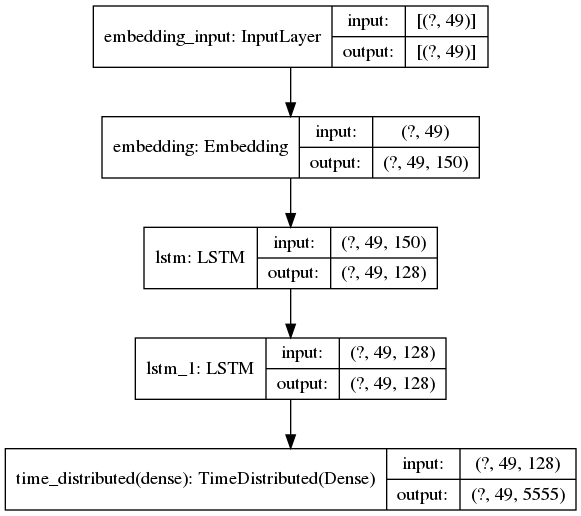

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

## 加载训练模型预测

In [28]:
## 读取字典
def read_vocab(vocab_path):
    vocab = []
    with open(vocab_path, 'r', encoding='utf-8') as f:
        for line in f:
            vocab.append(line.strip('\n'))
    f.close()
    return vocab

def get_word2idx_idx2word():
    dictionary = read_vocab('./data/vocab.txt')
    word2index = dict((value, key) for key, value in enumerate(dictionary))
    index2word = dict((key, value) for key, value in enumerate(dictionary))
    print('vocab size: ', len(word2index))
    return word2index, index2word

In [29]:
word2index, index2word = get_word2idx_idx2word()

vocab size:  5555


In [30]:
model = tf.keras.models.load_model("./models/textgene/rnnmodel.h5")
predict_data = ["秦时明月汉时关，"]
result = predict_poem(predict_data, model, word2index, index2word)
print(result)

predict data encoder finish
predict finish
predict length:  33
秦时明月汉时关，乡空风归思谁是，闲今将空衣江风。应花有是应不人，


In [31]:
## 加载模型训练
models = tf.keras.models.load_model("./models/textgene/rnnmodel.h5")
predict_data = ["秦时明月汉时关，"]
predict_data_encoder = predict_sent_encoder(predict_data, word2index)
predict_data_encoder_padding = poem_padding(predict_data_encoder)
print("padding ", predict_data_encoder_padding.shape)
result = models.predict(predict_data_encoder_padding)
print(result.shape)

predict data encoder finish
padding  (1, 49)
(1, 49, 5555)
